# G4Hive performance analysis

Let's look at some measurements of G4Hive jobs for different number of threads and make some plots. We want to look at how memory and throughput scale with the number of threads. We also want to look at the timing of algorithms in the job.

In [1]:
import os
import csv
import re
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.patches as mpatch
%matplotlib inline

# Prepare the data 

In [2]:
ls results/

log.10_0_1000.log       mem.10_0_1000.csv       timeline.10_0_1000.log
log.12_0_1000.log       mem.12_0_1000.csv       timeline.12_0_1000.log
log.14_0_1000.log       mem.14_0_1000.csv       timeline.14_0_1000.log
log.16_0_1000.log       mem.16_0_1000.csv       timeline.16_0_1000.log
log.18_0_1000.log       mem.18_0_1000.csv       timeline.18_0_1000.log
log.1_0_1000.log        mem.1_0_1000.csv        timeline.1_0_1000.log
log.20_0_1000.log       mem.20_0_1000.csv       timeline.20_0_1000.log
log.22_0_1000.log       mem.22_0_1000.csv       timeline.22_0_1000.log
log.24_0_1000.log       mem.24_0_1000.csv       timeline.24_0_1000.log
log.26_0_1000.log       mem.26_0_1000.csv       timeline.26_0_1000.log
log.28_0_1000.log       mem.28_0_1000.csv       timeline.28_0_1000.log
log.2_0_1000.log        mem.2_0_1000.csv        timeline.2_0_1000.log
log.30_0_1000.log       mem.30_0_1000.csv       timeline.30_0_1000.log
log.32_0_1000.log       mem.32_0_1000.csv       timeline.32_0_1000.log
log.3_0_

In [3]:
all_files = os.listdir('results')
mem_files = [f for f in all_files if f.startswith('mem.')]
#time_files = [f for f in all_files if f.startswith('times.')]
time_files = [f for f in all_files if f.startswith('timeline.')]

Let's take a peek at the format of these files

In [5]:
def peek_file(file):
    print('%s:' % file)
    with open(os.path.join('results', file)) as f:
        for line in f.readlines()[0:3]:
            print('    %s' % line.strip())
            
peek_file(mem_files[-1])
peek_file(time_files[-1])

mem.8_0_1000.csv:
    1463471606505486668,112
    1463471607658108662,4496
    1463471608868549885,5492
timeline.8_0_1000.log:
    1463471606308344466
    #start end algorithm thread slot event
    1463471724897703574 1463471724897718679 AthOutSeq 3495376640 0 0


Now we define some functions for parsing out the measurements from the log files.
I use numpy's genfromtxt to do most of the parsing:
http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.genfromtxt.html

In [20]:
def parse_job_info(file_name):
    """Parses out basic job info from the file-name.
    Returns nThread, nProc, nEvent
    """
    #x = re.match('\w+\.(\d+).(\d+)_(\d+)e\.\w+', file_name)
    #return tuple(map(int, x.groups()))
    config_str = file_name.split('.')[1]
    nThread, nProc, nEvent = config_str.split('_')
    return int(nThread), int(nProc), int(nEvent)

def parse_mem_file(mem_file):
    """Use numpy to parse the memory monitoring log file.
    Returns a structured 2D array of monitoring data."""
    return np.genfromtxt(os.path.join('results', mem_file),
                         delimiter=',', dtype='i8,i4',
                         names=['times', 'mems'])

def parse_time_file(time_file):
    """Extract job start and end time from a time log file"""
    with open(os.path.join('results', time_file)) as f:
        lines = f.readlines()
    start_time, end_time = int(lines[0]), int(lines[-1])
    return start_time, end_time

def parse_timeline(timeline):
    """Parse alg timing results for one job with numpy"""
    return np.genfromtxt(os.path.join('results', timeline),
                         skip_header=2, skip_footer=1,
                         dtype='i8,i8,S15,i4,i4,i4',
                         names=['starts', 'ends', 'algs', 'tids', 'slots', 'events'])

In [21]:
class JobResult:
    """A structure to hold all the measurements associated with one job"""
    def __init__(self, nThread, nProc, nEvent):
        self.nThread, self.nProc, self.nEvent = nThread, nProc, nEvent

In [30]:
job_results = []
for mem_file, time_file in zip(mem_files, time_files):
    nThread, nProc, nEvent = parse_job_info(mem_file)
    assert((nThread, nProc, nEvent) == parse_job_info(time_file))
    j = JobResult(nThread, nProc, nEvent)
    j.times_mems = parse_mem_file(mem_file)
    # Currently, I'm dumping the start/end times into the timeline file
    j.start_time, j.end_time = parse_time_file(time_file)
    j.timeline_results = parse_timeline(time_file)
    job_results.append(j)

# Sort results by nThread
job_results.sort(key=lambda j: j.nThread)

## Event throughput scaling

First, let's define some helper functions for dealing with job timing info.
Then, we will plot the event throughput as a function of number of threads.

In [33]:
def get_eventloop_time(job):
    """Calculates the time (in seconds) spent in the event loop for a given job"""
    algs_start = job.timeline_results['starts']
    algs_end = job.timeline_results['ends']
    return (algs_end.max() - algs_start.min())*1e-9

def get_throughput(job):
    """Calculate event throughput (events/s) for a job,
       ignoring initialization and finalization"""
    return job.nEvent / get_eventloop_time(job)

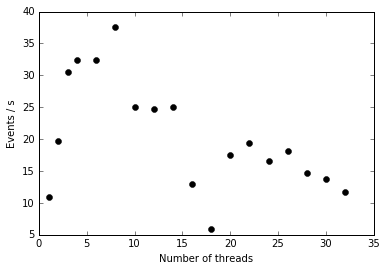

In [36]:
nThreads = np.array([j.nThread for j in job_results])
thruPuts = np.array([get_throughput(j) for j in job_results])
plt.figure()
plt.plot(nThreads, thruPuts, 'ko')
plt.xlabel('Number of threads')
plt.ylabel('Events / s');

## Memory scaling

Start with some helper functions for memory calculations, then plot memory footprint as a function of number of threads, as well as the memory in each job as a function of time.

In [37]:
def get_max_mem(job):
    """Calculate peak memory consumption in a job"""
    return job.times_mems['mems'].max()

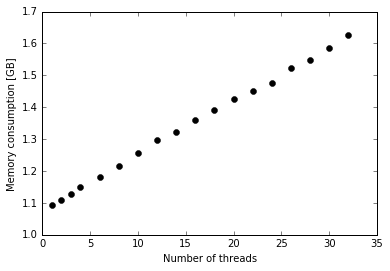

In [38]:
maxMems = np.array([get_max_mem(j)*1e-6 for j in job_results])
plt.figure()
plt.plot(nThreads, maxMems, 'ko')
plt.xlabel('Number of threads')
plt.ylabel('Memory consumption [GB]');

In [42]:
job_results[::3]

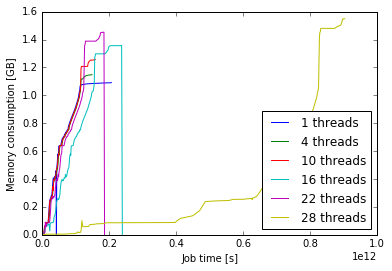

In [48]:
# Show memory as a function of job time
plt.figure()
for j in job_results[::3]:
    label = '%i threads' % j.nThread
    mems = j.times_mems['mems']*1e-6
    raw_times = j.times_mems['times']
    times = raw_times - raw_times[0]
    plt.plot(times, mems, label=label)
plt.xlabel('Job time [s]')
plt.ylabel('Memory consumption [GB]')
plt.legend(loc=4);

## Algorithm analysis

Let's take a look at how the job breaks down by algorithm. We'd like to know how much time is spent in each algorithm and the timing distributions look for each alg.

I'll need to figure out how to make a histogram in matplotlib.

For the timeline plot, the following links may be useful:
* http://stackoverflow.com/questions/7684475/plotting-labeled-intervals-in-matplotlib-gnuplot
* http://www.clowersresearch.com/main/gantt-charts-in-matplotlib/
* http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.broken_barh

To make the timeline plot, I think I will try to use the broken_barh in pyplot. Let's play around with it.

In [49]:
# For the timeline plot, we'll look at just one job for now
j = job_results[3]

# Get a subset of the timeline data to start with
timelines = j.timeline_results[0:600]
print(timelines[0:5])

[(1463471421547378626, 1463471421547389956, b'AthOutSeq', -795392256, 0, 0)
 (1463471421547386457, 1463471421547396680, b'AthRegSeq', -803789056, 0, 0)
 (1463471421547390798, 1463471421547616987, b'SGInputLoader', -791193856, 1, 1)
 (1463471421547388037, 1463471421547680159, b'SGInputLoader', -799590656, 0, 0)
 (1463471421547950150, 1463471421547950595, b'AthOutSeq', -795392256, 1, 1)]


In [50]:
# Get the unique thread IDs
tids = timelines['tids']
unique_tids = np.unique(tids)
assert(len(unique_tids) == j.nThread) # sanity check

# Now split the timeline results by thread ID
timelines_by_thread = [timelines[tids == tid] for tid in unique_tids]

In [51]:
def get_time_bars(timeline, start_time):
    """
    Calculate and format the timeline info in the form needed by broken_hbar.
    Receives: a list of timeline info, probably for one thread, and a
      global start time to normalize to.
    Returns: a list of (start, duration) for each item in the input list.
    """
    # Calculate durations
    raw_starts, raw_ends = timeline['starts'], timeline['ends']
    durations = raw_ends - raw_starts
    # Shift start to zero
    starts = raw_starts - start_time
    assert(starts.min() >= 0)
    # Convert to seconds in final list
    time_bars = np.column_stack((starts, durations))*1e-9
    return time_bars

In [52]:
# A color map for the algorithms
alg_color_map = {'SGInputLoader' : 'black',
                 'BeamEffectsAlg' : 'blue',
                 'G4AtlasAlg' : 'red',
                 'StreamHITS' : 'green',
                 #'AthOutSeq' : 'yellow',
                 #'AthRegSeq' : 'purple',
                }

def get_timeline_colors(timeline):
    """Get color list for the algs in timeline data"""
    algs = timeline['algs']
    colors = [alg_color_map.get(a.decode('UTF-8'), 'black') for a in algs]
    return colors

In [53]:
# Event loop start time
start_time = timelines['starts'].min()
# Plot values by thread index
times_by_thread = [get_time_bars(t, start_time) for t in timelines_by_thread]
colors_by_thread = [get_timeline_colors(t) for t in timelines_by_thread]

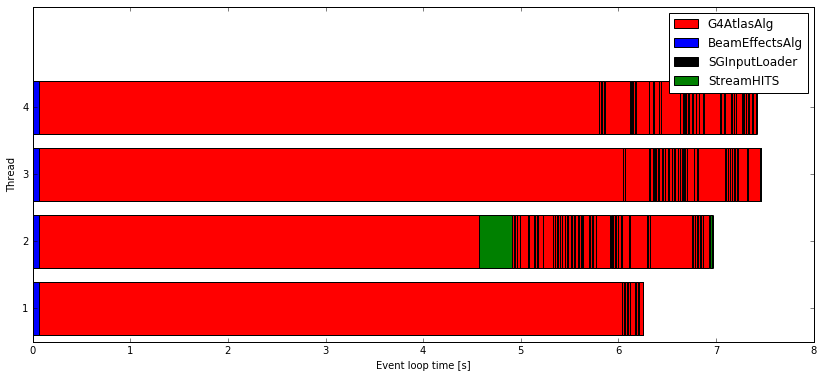

In [54]:
# Prepare the plot
plt.figure(figsize=(14, 6))
for i, (time_bars, colors) in enumerate(zip(times_by_thread, colors_by_thread)):
    dy = 0.8
    y1 = (i + 1.) - dy/2
    plt.broken_barh(time_bars, [y1, dy], facecolors=colors)
# Fake bar objects to populate the legend
legbars = [mpatch.Rectangle((0, 0), 1, 1, fc=c) for c in alg_color_map.values()]
plt.xlabel('Event loop time [s]')
plt.ylabel('Thread')
plt.yticks(range(1, len(unique_tids)+1))
plt.ylim(ymax=len(unique_tids)+1.5)
plt.xlim(xmin=0)
plt.legend(legbars, alg_color_map.keys(), loc=1);